In [7]:
# --- INSTALLS ---
# Kaggle usually has these, but good to ensure versions
!pip install -q scikit-learn==1.5.2
!pip install -q nltk==3.9.1 tqdm==4.66.5
!pip install -q lightgbm==4.5.0

# --- IMPORTS ---
import os, re, string, pickle, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import lightgbm as lgb # <--- CHANGED TO LIGHTGBM

from tqdm import tqdm
from pprint import pprint

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MultiLabelBinarizer
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support, classification_report,
                             confusion_matrix, roc_auc_score, roc_curve, auc,
                             average_precision_score, precision_recall_curve)
from sklearn.utils.class_weight import compute_class_weight

from scipy import sparse

# --- TEXT PREP (NLTK) ---\
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize

# --- TF-IDF ---
from sklearn.feature_extraction.text import TfidfVectorizer

# --- PLOTTING ---
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.dpi"] = 130

RNG = 42
N_CLASSES = 3

# --- PATHS (KAGGLE SPECIFIC) ---
# IMPORTANT: Update 'your-dataset-name' to the actual folder name in Kaggle inputs
# It usually looks like: /kaggle/input/movie-reviews-dataset/Composite2_194k data.csv
CSV_PATH = "/kaggle/input/composite-2-194k-ml/Composite2_194k data.csv" 
BASE_SAVE_DIR = "/kaggle/working/LightGBM_Multiclass"
os.makedirs(BASE_SAVE_DIR, exist_ok=True)

# --- LOAD ---
# Check if file exists to prevent crash
if not os.path.exists(CSV_PATH):
    print(f"WARNING: File not found at {CSV_PATH}. Please check your Kaggle Input path.")
else:
    df = pd.read_csv(CSV_PATH)

    # --- BASIC CLEANING (MULTICLASS VERSION) ---
    need = ['title','reviewText','target_label','tomatoMeter','genre','audienceScore',
            'runtimeMinutes','language_encoded','director_encoded']
    missing = [c for c in need if c not in df.columns]
    
    if not missing:
        # Drop rows with missing target or review text
        df = df.dropna(subset=['reviewText','target_label']).copy()
        df['label'] = df['target_label'].astype(int)

        # Verify we have 3 classes: 0 (Negative), 1 (Neutral), 2 (Positive)
        assert df['label'].isin([0, 1, 2]).all(), "Labels must be 0, 1, or 2"

        # Keep only needed columns
        df['title'] = df['title'].fillna("")
        df['genre'] = df['genre'].fillna("Unknown")

        class_names = ['Negative', 'Neutral', 'Positive']
        print("Rows:", len(df))
        print("Class distribution:")
        print(df['label'].value_counts().sort_index())
        print("\nClass proportions:")
        print(df['label'].value_counts(normalize=True).sort_index().round(4))

# --- TEXT PREPROCESSING ---
STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def clean_text(s: str) -> str:
    if not isinstance(s, str):
        s = "" if pd.isna(s) else str(s)
    s = s.lower()
    # contractions (quick pass)
    s = re.sub(r"'", "'", s)
    s = re.sub(r"n't\b", " not", s)
    s = re.sub(r"'re\b", " are", s)
    s = re.sub(r"'s\b", " is", s)
    s = re.sub(r"'d\b", " would", s)
    s = re.sub(r"'ll\b", " will", s)
    s = re.sub(r"'ve\b", " have", s)
    s = re.sub(r"'m\b", " am", s)
    # remove urls/emails/handles
    s = re.sub(r"http\S+|www\.\S+|[\w\.-]+@[\w\.-]+", " ", s)
    # keep letters only
    s = re.sub(r"[^a-z\s]", " ", s)
    # tokenize → remove stopwords → lemmatize → (light) stem
    tokens = [w for w in word_tokenize(s) if w not in STOPWORDS and len(w) > 2]
    lemmas = [lemmatizer.lemmatize(w) for w in tokens]
    stems  = [stemmer.stem(w) for w in lemmas]
    return " ".join(stems)

def fit_tfidf(train_texts, max_features=50000, ngram_range=(1,2), min_df=3):
    vec = TfidfVectorizer(
        preprocessor=None,
        tokenizer=None,
        analyzer='word',
        ngram_range=ngram_range,
        min_df=min_df,
        max_features=max_features,
        lowercase=False,
        dtype=np.float32
    )
    X = vec.fit_transform(train_texts)
    return vec, X

def transform_tfidf(vec, texts):
    return vec.transform(texts)

print("\n✅ Part 1 Complete: Data loaded and preprocessing functions defined.")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Rows: 194784
Class distribution:
label
0    55029
1    66081
2    73674
Name: count, dtype: int64

Class proportions:
label
0    0.2825
1    0.3393
2    0.3782
Name: proportion, dtype: float64

✅ Part 1 Complete: Data loaded and preprocessing functions defined.


In [8]:
# --- MULTICLASS FEATURE ENGINEERING ---

NUM_COLS = ['tomatoMeter', 'audienceScore', 'runtimeMinutes']

# =======================================================
# MULTICLASS DIRECTOR BLOCKS (Target Encoding)
# =======================================================
def director_blocks_multiclass(train_s: pd.Series, y: np.ndarray, test_s: pd.Series, n_splits: int = 5):
    """
    Multiclass Target Encoding: Calculates mean for each class (0, 1, 2)
    Returns 1 freq col + 3 target mean cols (4 total features per director).
    """
    s_train = train_s.fillna("Unknown").astype(str)
    s_test  = test_s.fillna("Unknown").astype(str)

    # 1. Frequency features (log1p)
    freq = s_train.value_counts()
    tr_freq = np.log1p(s_train.map(freq).fillna(0).astype(float).values)[:, None].astype(np.float32)
    te_freq = np.log1p(s_test.map(freq).fillna(0).astype(float).values)[:, None].astype(np.float32)

    # 2. Multiclass Target mean encoding (leak-safe OOF)
    y_ohe = OneHotEncoder(categories=[range(N_CLASSES)], sparse_output=False, dtype=np.float32).fit_transform(y.reshape(-1, 1))
    global_mean = y_ohe.mean(axis=0)

    tr_te = np.zeros((len(s_train), N_CLASSES), dtype=np.float32)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RNG)

    for tr_i, val_i in skf.split(np.zeros(len(y)), y):
        tr_fold = s_train.iloc[tr_i]
        fold_means = pd.DataFrame(y_ohe[tr_i], index=tr_fold.index).groupby(tr_fold).mean()

        val_fold = s_train.iloc[val_i].to_frame(name='did')
        merged = val_fold.merge(fold_means, left_on='did', right_index=True, how='left')
        vals = merged.drop('did', axis=1).values

        mask = np.isnan(vals.sum(axis=1))
        vals[mask] = global_mean
        tr_te[val_i] = vals.astype(np.float32)

    # Test set mapping (using full train)
    full_means = pd.DataFrame(y_ohe, index=s_train.index).groupby(s_train).mean()
    test_df_map = s_test.to_frame(name='did')
    merged_test = test_df_map.merge(full_means, left_on='did', right_index=True, how='left')
    te_te = merged_test.drop('did', axis=1).values

    mask_test = np.isnan(te_te.sum(axis=1))
    te_te[mask_test] = global_mean

    return tr_freq, te_freq, tr_te, te_te

# =======================================================
# GENRE & LANGUAGE ENCODINGS
# =======================================================
def fit_categoricals(train_genre, train_lang):
    mlb = MultiLabelBinarizer()
    G = mlb.fit_transform(train_genre)

    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True, dtype=np.float32)
    L = ohe.fit_transform(train_lang.to_frame(name="lang"))
    return mlb, ohe, G, L

def transform_categoricals(mlb, ohe, genre_series, lang_series):
    G = mlb.transform(genre_series)
    L = ohe.transform(lang_series.to_frame(name="lang"))
    return G, L

# =======================================================
# NUMERICS: scale on TRAIN only
# =======================================================
def fit_scale_numeric(train_df, cols):
    scaler = StandardScaler()
    X = scaler.fit_transform(train_df[cols].fillna(train_df[cols].median()))
    return scaler, X

def transform_scale_numeric(scaler, df, cols):
    return scaler.transform(df[cols].fillna(df[cols].median()))

# =======================================================
# TRAIN/TEST SPLIT (Stratified by 3 classes)
# =======================================================
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=RNG, stratify=df['label']
)
y_train = train_df['label'].values
y_test = test_df['label'].values

print(f"\nTrain size: {len(train_df)} | Test size: {len(test_df)}")
print("Train class distribution:")
print(pd.Series(y_train).value_counts().sort_index())
print("\nTest class distribution:")
print(pd.Series(y_test).value_counts().sort_index())

# =======================================================
# COMPUTE CLASS WEIGHTS (for imbalanced 3-class data)
# =======================================================
class_weights = compute_class_weight('balanced', classes=np.array([0, 1, 2]), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1], 2: class_weights[2]}
print(f"\nClass weights: {class_weight_dict}")

print("\n✅ Part 2 Complete: Feature engineering functions and train/test split ready.")


Train size: 155827 | Test size: 38957
Train class distribution:
0    44023
1    52865
2    58939
Name: count, dtype: int64

Test class distribution:
0    11006
1    13216
2    14735
Name: count, dtype: int64

Class weights: {0: 1.1798908146499179, 1: 0.9825467385478736, 2: 0.8812896949953907}

✅ Part 2 Complete: Feature engineering functions and train/test split ready.


In [9]:
# =======================================================
# MULTICLASS EVALUATION & PLOTTING (4-DECIMAL PRECISION)
# =======================================================

def evaluate_and_plot(model_name, setup_name, y_true, y_prob, y_pred, save_dir, class_names=['Negative', 'Neutral', 'Positive']):
    """
    Multiclass evaluation with 4-decimal precision.
    """
    os.makedirs(save_dir, exist_ok=True)
    n_classes = len(class_names)

    # Calculate metrics with weighted average (for imbalanced data)
    acc  = accuracy_score(y_true, y_pred)
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)

    print(f"\n[{setup_name} | {model_name}]")
    print(f"Accuracy={acc:.4f}  F1_weighted={f1:.4f}  Precision_weighted={pr:.4f}  Recall_weighted={rc:.4f}")

    # ⭐ 4-DECIMAL CLASSIFICATION REPORT
    print("\n--- Classification Report (4 Decimal Places) ---")
    report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0, digits=4)
    print(report)

    # ⭐ CONFUSION MATRIX (Counts + Normalized with 4 decimals)
    cm = confusion_matrix(y_true, y_pred, labels=range(n_classes))
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(12, 5))

    # Counts (Integers)
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{setup_name} | {model_name}\nConfusion Matrix (Counts)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # ⭐ 4-DECIMAL NORMALIZED CONFUSION MATRIX
    plt.subplot(1, 2, 2)
    sns.heatmap(cm_norm, annot=True, fmt='.4f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{setup_name} | {model_name}\nConfusion Matrix (Normalized, 4-Decimals)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'{model_name}_{setup_name}_confusion.png'), dpi=130, bbox_inches='tight')
    plt.show()

    # Per-class metrics
    pr_per_class, rc_per_class, f1_per_class, support = precision_recall_fscore_support(
        y_true, y_pred, labels=range(n_classes), zero_division=0
    )

    print("\n--- Per-Class Metrics (4 Decimals) ---")
    for i, cname in enumerate(class_names):
        print(f"{cname:10s}: Precision={pr_per_class[i]:.4f}  Recall={rc_per_class[i]:.4f}  F1={f1_per_class[i]:.4f}  Support={support[i]}")

    return {
        "accuracy": acc,
        "f1_weighted": f1,
        "precision_weighted": pr,
        "recall_weighted": rc,
        "per_class_precision": pr_per_class,
        "per_class_recall": rc_per_class,
        "per_class_f1": f1_per_class
    }

print("\n✅ Part 3 Complete: Multiclass evaluation helpers ready (4-decimal precision).")


✅ Part 3 Complete: Multiclass evaluation helpers ready (4-decimal precision).


In [10]:
# =======================================================
# BUILD ALL FEATURE MATRICES (8 Features: Review + Title + Num + Genre + Lang + Director)
# =======================================================

print("--- Building ALL Features Matrix ---")

# ---- TEXT FEATURES ----
# 1. Review Text
train_review = train_df['reviewText'].map(clean_text)
test_review  = test_df['reviewText'].map(clean_text)
tfidf_review, Xtr_review = fit_tfidf(train_review, max_features=60000, ngram_range=(1,2), min_df=3)
Xte_review = transform_tfidf(tfidf_review, test_review)

# 2. Title Text
train_title = train_df['title'].map(clean_text)
test_title  = test_df['title'].map(clean_text)
tfidf_title, Xtr_title = fit_tfidf(train_title, max_features=30000, ngram_range=(1,2), min_df=3)
Xte_title = transform_tfidf(tfidf_title, test_title)

# ---- NUMERIC FEATURES ----
scaler_all, Xtr_num_np = fit_scale_numeric(train_df, NUM_COLS)
Xte_num_np = transform_scale_numeric(scaler_all, test_df, NUM_COLS)
Xtr_num = sparse.csr_matrix(Xtr_num_np.astype(np.float32))
Xte_num = sparse.csr_matrix(Xte_num_np.astype(np.float32))

# ---- CATEGORICAL FEATURES ----
# Genre (multi-label)
train_genre = train_df['genre'].fillna("Unknown").str.split(', ')
test_genre  = test_df['genre'].fillna("Unknown").str.split(', ')

# Language (single label)
train_lang  = train_df['language_encoded'].astype('Int64').astype(str).fillna('unknown')
test_lang   = test_df['language_encoded'].astype('Int64').astype(str).fillna('unknown')

mlb_all, ohe_all, Xtr_genre, Xtr_lang = fit_categoricals(train_genre, train_lang)
Xte_genre, Xte_lang = transform_categoricals(mlb_all, ohe_all, test_genre, test_lang)

Xtr_genre = sparse.csr_matrix(Xtr_genre.astype(np.float32))
Xte_genre = sparse.csr_matrix(Xte_genre.astype(np.float32))

# ---- DIRECTOR FEATURES (Multiclass Target Encoding) ----
tr_f, te_f, tr_te, te_te = director_blocks_multiclass(
    train_df['director_encoded'], y_train, test_df['director_encoded']
)
Xtr_dir = sparse.csr_matrix(np.concatenate([tr_f, tr_te], axis=1).astype(np.float32))
Xte_dir = sparse.csr_matrix(np.concatenate([te_f, te_te], axis=1).astype(np.float32))

# ---- STACK ALL FEATURES ----
X_train_ALL = sparse.hstack([Xtr_review, Xtr_title, Xtr_num, Xtr_genre, Xtr_lang, Xtr_dir], format='csr')
X_test_ALL  = sparse.hstack([Xte_review, Xte_title, Xte_num, Xte_genre, Xte_lang, Xte_dir], format='csr')

print("\n--- Feature Matrix Stacking Complete ---")
print(f"X_train_ALL shape: {X_train_ALL.shape}")
print(f"X_test_ALL shape:  {X_test_ALL.shape}")
print(f"Features include: Review TF-IDF, Title TF-IDF, Numerics, Genre, Language, Director (Total: {X_train_ALL.shape[1]} features)")

print("\n✅ Part 4 Complete: ALL features matrix ready.")

--- Building ALL Features Matrix ---

--- Feature Matrix Stacking Complete ---
X_train_ALL shape: (155827, 83942)
X_test_ALL shape:  (38957, 83942)
Features include: Review TF-IDF, Title TF-IDF, Numerics, Genre, Language, Director (Total: 83942 features)

✅ Part 4 Complete: ALL features matrix ready.



LIGHTGBM — ALL FEATURES (Multiclass)
Creating LightGBM Datasets...

Running 5-Fold Cross-Validation...
  Fold 1: acc=0.6358 | f1_weighted=0.6325
  Fold 2: acc=0.6374 | f1_weighted=0.6339
  Fold 3: acc=0.6408 | f1_weighted=0.6379
  Fold 4: acc=0.6352 | f1_weighted=0.6317
  Fold 5: acc=0.6385 | f1_weighted=0.6355
  LightGBM (ALL Features) CV mean±std | acc=0.6375±0.0020 f1_w=0.6343±0.0022

Training on full training set...
Training until validation scores don't improve for 50 rounds
[100]	train's multi_logloss: 0.782831	test's multi_logloss: 0.818697
[200]	train's multi_logloss: 0.744456	test's multi_logloss: 0.798948
[300]	train's multi_logloss: 0.718169	test's multi_logloss: 0.787659
[400]	train's multi_logloss: 0.698123	test's multi_logloss: 0.779698
[500]	train's multi_logloss: 0.680313	test's multi_logloss: 0.773759
[600]	train's multi_logloss: 0.665646	test's multi_logloss: 0.769407
[700]	train's multi_logloss: 0.652253	test's multi_logloss: 0.765949
[800]	train's multi_logloss: 0.

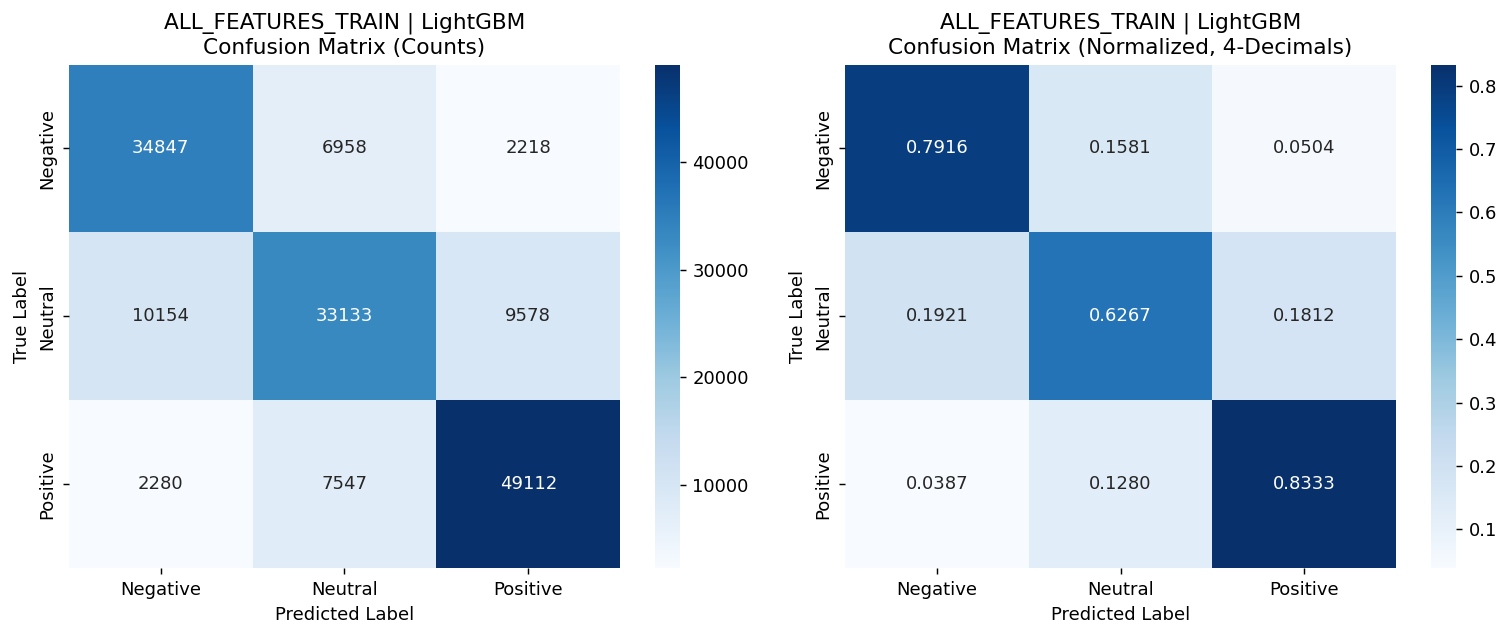


--- Per-Class Metrics (4 Decimals) ---
Negative  : Precision=0.7370  Recall=0.7916  F1=0.7633  Support=44023
Neutral   : Precision=0.6955  Recall=0.6267  F1=0.6593  Support=52865
Positive  : Precision=0.8063  Recall=0.8333  F1=0.8196  Support=58939

TEST SET PERFORMANCE

[ALL_FEATURES_TEST | LightGBM]
Accuracy=0.6435  F1_weighted=0.6407  Precision_weighted=0.6392  Recall_weighted=0.6435

--- Classification Report (4 Decimal Places) ---
              precision    recall  f1-score   support

    Negative     0.6342    0.6799    0.6563     11006
     Neutral     0.5298    0.4822    0.5049     13216
    Positive     0.7410    0.7608    0.7508     14735

    accuracy                         0.6435     38957
   macro avg     0.6350    0.6410    0.6373     38957
weighted avg     0.6392    0.6435    0.6407     38957



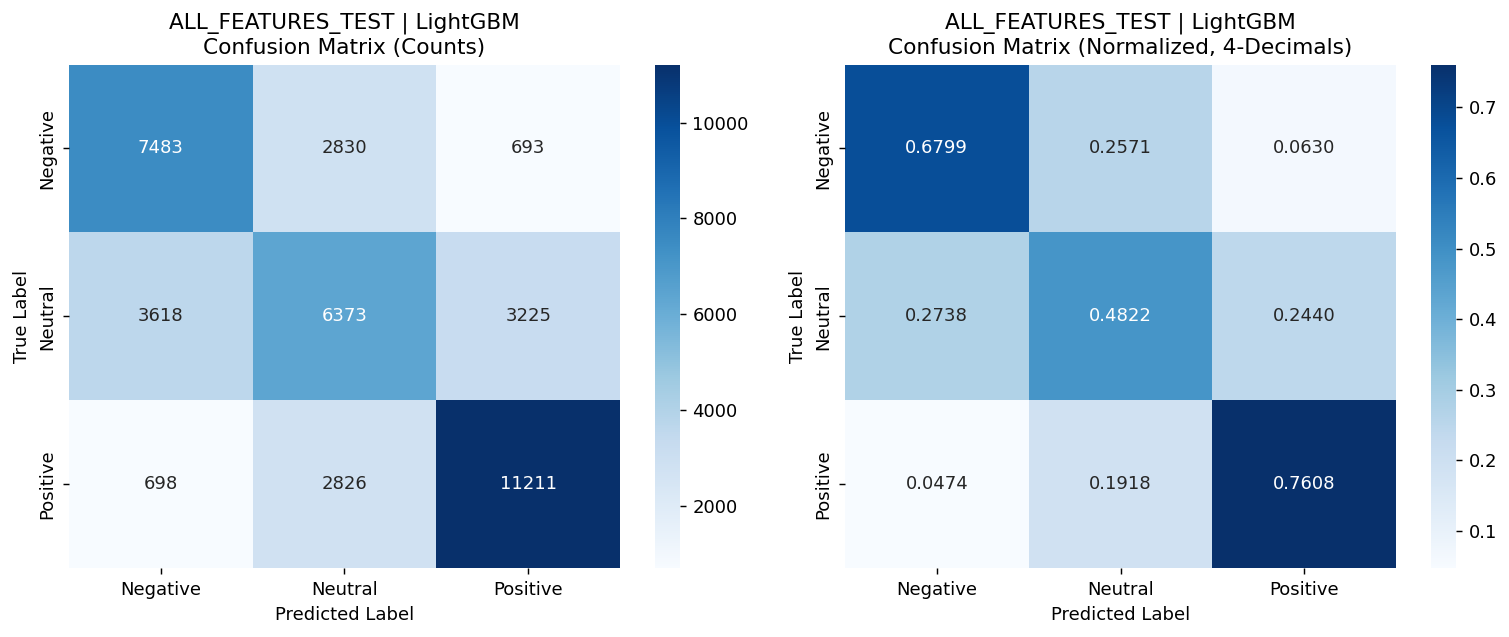


--- Per-Class Metrics (4 Decimals) ---
Negative  : Precision=0.6342  Recall=0.6799  F1=0.6563  Support=11006
Neutral   : Precision=0.5298  Recall=0.4822  F1=0.5049  Support=13216
Positive  : Precision=0.7410  Recall=0.7608  F1=0.7508  Support=14735

✅ Model saved to: /kaggle/working/LightGBM_Multiclass/ALL_FEATURES/LightGBM_ALL_Multiclass.pkl
Plotting feature importance...


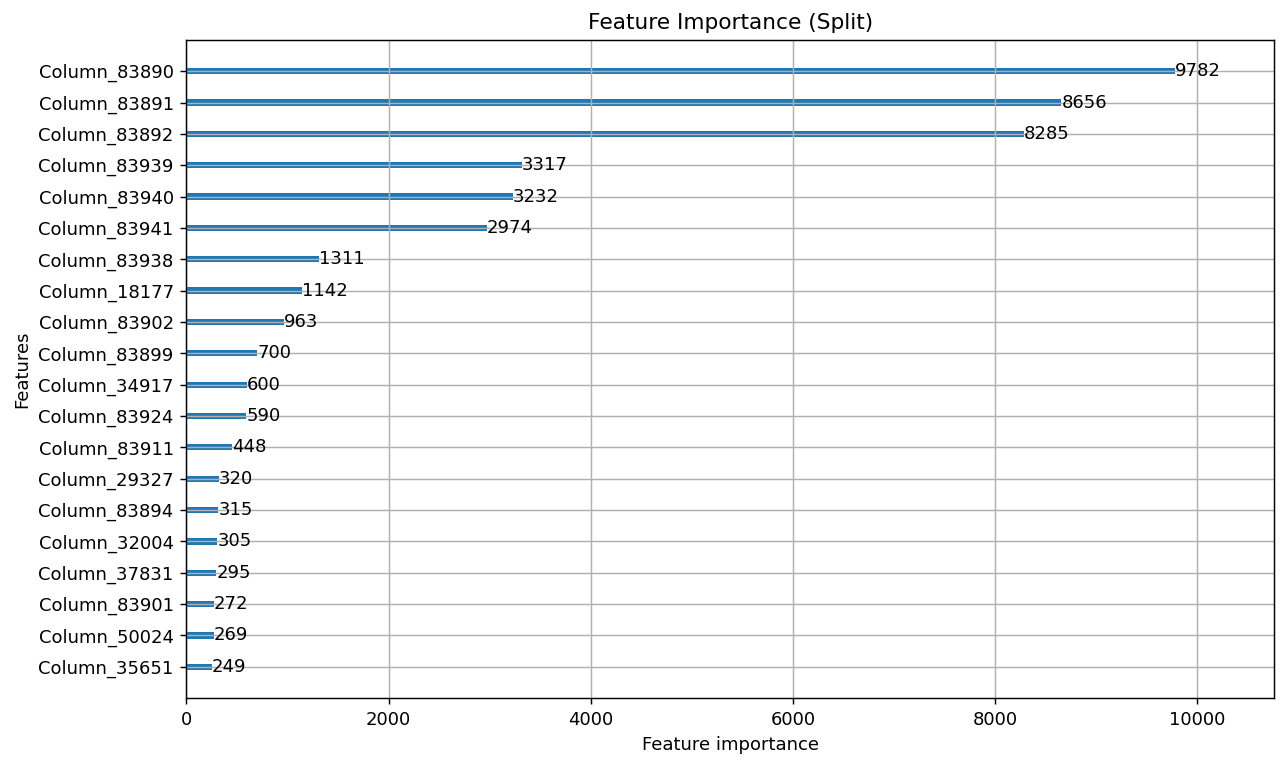

In [11]:
# ======================================================================
# LIGHTGBM — ALL FEATURES (CPU Optimized for Sparse Data)
# ======================================================================

setup = "ALL_FEATURES"
save_dir = os.path.join(BASE_SAVE_DIR, setup)
os.makedirs(save_dir, exist_ok=True)

print(f"\n{'='*70}")
print(f"LIGHTGBM — ALL FEATURES (Multiclass)")
print(f"{'='*70}")

# Create LightGBM Dataset
# Note: LightGBM handles sparse matrices natively
print("Creating LightGBM Datasets...")
sample_weights_train = np.array([class_weight_dict[label] for label in y_train])
train_data_all = lgb.Dataset(X_train_ALL, label=y_train, weight=sample_weights_train)
test_data_all = lgb.Dataset(X_test_ALL, label=y_test, reference=train_data_all)

# ⭐ LIGHTGBM MULTICLASS CLASSIFICATION PARAMS
lgb_params = {
    'objective': 'multiclass',
    'num_class': N_CLASSES,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    
    # Model Complexity
    'max_depth': 8,
    'num_leaves': 128,  
    'learning_rate': 0.1,
    
    # Regularization & Sampling
    'bagging_fraction': 0.8, # subsample
    'bagging_freq': 1,
    'feature_fraction': 0.8, # colsample_bytree
    'min_child_weight': 5,
    'lambda_l1': 0.1, # reg_alpha
    'lambda_l2': 1.0, # reg_lambda
    
    # SWITCH TO CPU FOR STABILITY WITH SPARSE DATA
    'device': 'cpu', 
    'n_jobs': -1,  # Use all available Kaggle CPU cores
    
    'seed': RNG,
    'verbose': -1
}

# ---- K-FOLD CROSS-VALIDATION ----
print("\nRunning 5-Fold Cross-Validation...")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG)
cv_scores = []

for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train_ALL, y_train), 1):
    X_tr_fold = X_train_ALL[tr_idx]
    X_val_fold = X_train_ALL[val_idx]
    y_tr_fold = y_train[tr_idx]
    y_val_fold = y_train[val_idx]
    
    w_tr_fold = np.array([class_weight_dict[label] for label in y_tr_fold])
    
    dtrain_fold = lgb.Dataset(X_tr_fold, label=y_tr_fold, weight=w_tr_fold)
    dval_fold = lgb.Dataset(X_val_fold, label=y_val_fold, reference=dtrain_fold)
    
    callbacks = [
        lgb.early_stopping(stopping_rounds=50, verbose=False),
        lgb.log_evaluation(period=0) # Silence per-fold logs
    ]
    
    model_fold = lgb.train(
        lgb_params,
        dtrain_fold,
        num_boost_round=1000,
        valid_sets=[dtrain_fold, dval_fold],
        callbacks=callbacks
    )
    
    # Predict
    y_pred_prob_fold = model_fold.predict(X_val_fold)
    y_pred_fold = np.argmax(y_pred_prob_fold, axis=1)
    
    acc = accuracy_score(y_val_fold, y_pred_fold)
    f1 = precision_recall_fscore_support(y_val_fold, y_pred_fold, average='weighted', zero_division=0)[2]
    cv_scores.append((acc, f1))
    print(f"  Fold {fold}: acc={acc:.4f} | f1_weighted={f1:.4f}")

cv_arr = np.array(cv_scores)
print(f"  LightGBM (ALL Features) CV mean±std | acc={cv_arr[:,0].mean():.4f}±{cv_arr[:,0].std():.4f} f1_w={cv_arr[:,1].mean():.4f}±{cv_arr[:,1].std():.4f}")

# ---- FIT ON FULL TRAIN ----
print("\nTraining on full training set...")
callbacks = [
    lgb.early_stopping(stopping_rounds=50),
    lgb.log_evaluation(period=100)
]

lgb_all = lgb.train(
    lgb_params,
    train_data_all,
    num_boost_round=1000,
    valid_sets=[train_data_all, test_data_all],
    valid_names=['train', 'test'],
    callbacks=callbacks
)

# ---- PREDICTIONS ----
print("\nMaking predictions...")
train_prob = lgb_all.predict(X_train_ALL)
train_pred = np.argmax(train_prob, axis=1)

test_prob = lgb_all.predict(X_test_ALL)
test_pred = np.argmax(test_prob, axis=1)

# ---- EVALUATION ----
print(f"\n{'='*70}")
print("TRAIN SET PERFORMANCE")
print(f"{'='*70}")
train_metrics = evaluate_and_plot(
    "LightGBM", f"{setup}_TRAIN", y_train, train_prob, train_pred, save_dir
)

print(f"\n{'='*70}")
print("TEST SET PERFORMANCE")
print(f"{'='*70}")
test_metrics = evaluate_and_plot(
    "LightGBM", f"{setup}_TEST", y_test, test_prob, test_pred, save_dir
)

# ---- SAVE MODEL ----
model_path = os.path.join(save_dir, "LightGBM_ALL_Multiclass.pkl")
with open(model_path, "wb") as f:
    pickle.dump({
        "model": lgb_all,
        "tfidf_review": tfidf_review,
        "tfidf_title": tfidf_title,
        "scaler": scaler_all,
        "mlb": mlb_all,
        "ohe": ohe_all,
        "num_cols": NUM_COLS,
        "class_names": class_names,
        "class_weight_dict": class_weight_dict,
        "lgb_params": lgb_params
    }, f)

print(f"\n✅ Model saved to: {model_path}")



LIGHTGBM — ALL FEATURES (Multiclass)
Creating LightGBM Datasets...

Running 5-Fold Cross-Validation...
  Fold 1: acc=0.6362 | f1_weighted=0.6328
  Fold 2: acc=0.6363 | f1_weighted=0.6327
  Fold 3: acc=0.6380 | f1_weighted=0.6345
  Fold 4: acc=0.6323 | f1_weighted=0.6289
  Fold 5: acc=0.6370 | f1_weighted=0.6335
  LightGBM (ALL Features) CV mean±std | acc=0.6360±0.0019 f1_w=0.6325±0.0019

Training on full training set...
Training until validation scores don't improve for 50 rounds
[100]	train's multi_logloss: 0.820396	test's multi_logloss: 0.833596
[200]	train's multi_logloss: 0.790931	test's multi_logloss: 0.81442
[300]	train's multi_logloss: 0.770327	test's multi_logloss: 0.80269
[400]	train's multi_logloss: 0.754432	test's multi_logloss: 0.794209
[500]	train's multi_logloss: 0.740461	test's multi_logloss: 0.787503
[600]	train's multi_logloss: 0.728667	test's multi_logloss: 0.782455
[700]	train's multi_logloss: 0.717974	test's multi_logloss: 0.778161
[800]	train's multi_logloss: 0.70

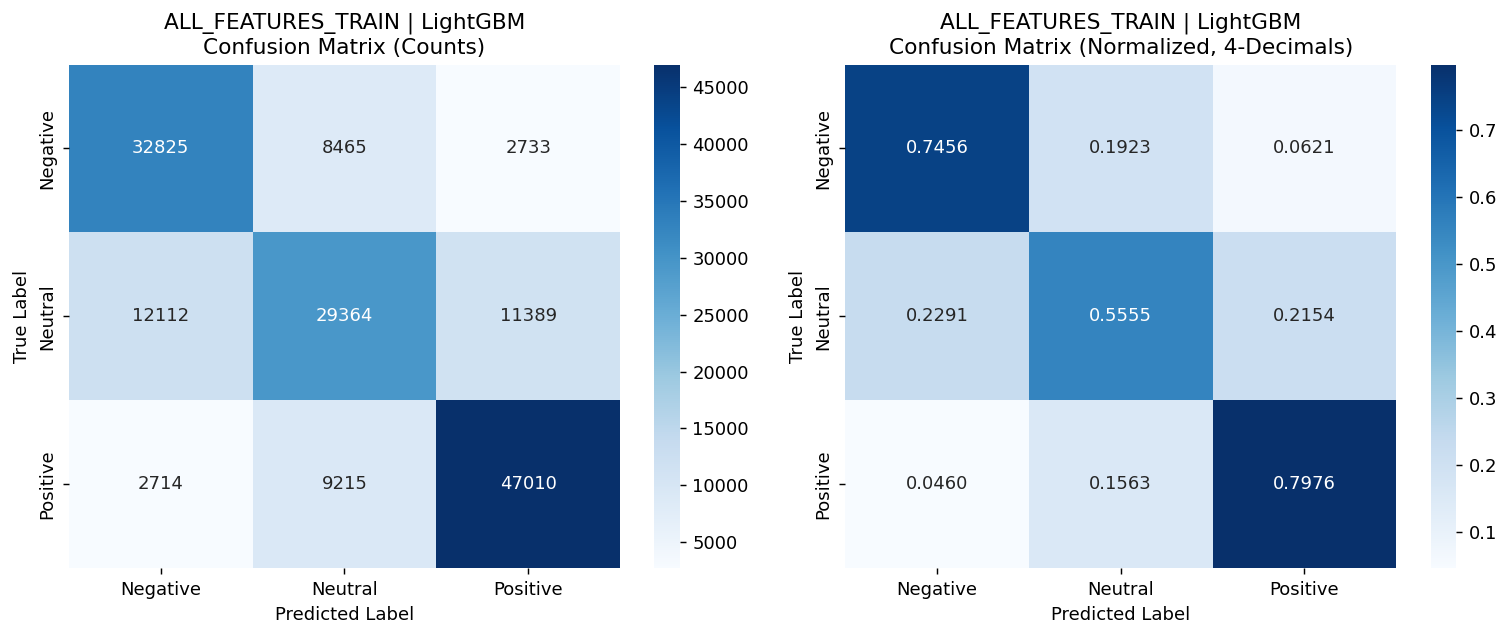


--- Per-Class Metrics (4 Decimals) ---
Negative  : Precision=0.6889  Recall=0.7456  F1=0.7161  Support=44023
Neutral   : Precision=0.6242  Recall=0.5555  F1=0.5878  Support=52865
Positive  : Precision=0.7690  Recall=0.7976  F1=0.7830  Support=58939

TEST SET PERFORMANCE

[ALL_FEATURES_TEST | LightGBM]
Accuracy=0.6378  F1_weighted=0.6343  Precision_weighted=0.6328  Recall_weighted=0.6378

--- Classification Report (4 Decimal Places) ---
              precision    recall  f1-score   support

    Negative     0.6250    0.6804    0.6515     11006
     Neutral     0.5263    0.4680    0.4954     13216
    Positive     0.7341    0.7583    0.7460     14735

    accuracy                         0.6378     38957
   macro avg     0.6284    0.6356    0.6310     38957
weighted avg     0.6328    0.6378    0.6343     38957



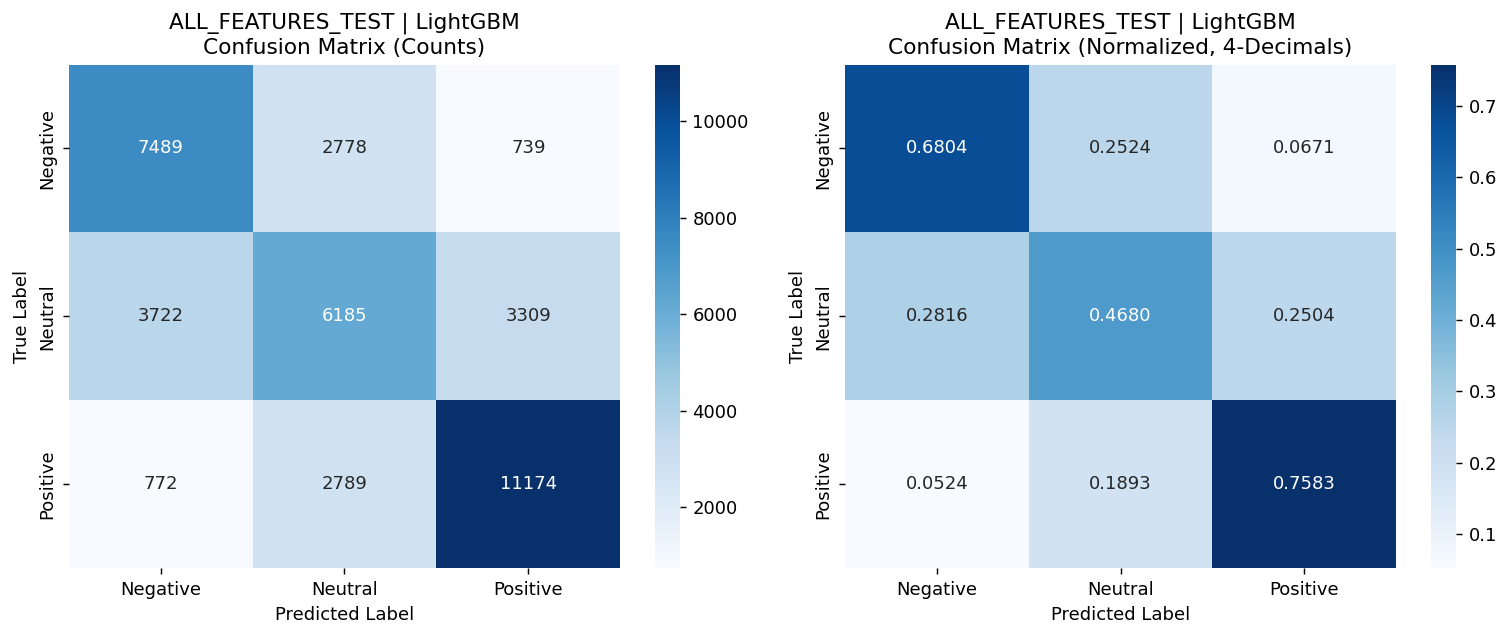


--- Per-Class Metrics (4 Decimals) ---
Negative  : Precision=0.6250  Recall=0.6804  F1=0.6515  Support=11006
Neutral   : Precision=0.5263  Recall=0.4680  F1=0.4954  Support=13216
Positive  : Precision=0.7341  Recall=0.7583  F1=0.7460  Support=14735

✅ Model saved to: /kaggle/working/LightGBM_Multiclass/ALL_FEATURES/LightGBM_ALL_Multiclass.pkl


In [13]:
# ======================================================================
# LIGHTGBM — ALL FEATURES (CPU Optimized for Sparse Data)
# ======================================================================

setup = "ALL_FEATURES"
save_dir = os.path.join(BASE_SAVE_DIR, setup)
os.makedirs(save_dir, exist_ok=True)

print(f"\n{'='*70}")
print(f"LIGHTGBM — ALL FEATURES (Multiclass)")
print(f"{'='*70}")

# Create LightGBM Dataset
# Note: LightGBM handles sparse matrices natively
print("Creating LightGBM Datasets...")
sample_weights_train = np.array([class_weight_dict[label] for label in y_train])
train_data_all = lgb.Dataset(X_train_ALL, label=y_train, weight=sample_weights_train)
test_data_all = lgb.Dataset(X_test_ALL, label=y_test, reference=train_data_all)

# ⭐ LIGHTGBM MULTICLASS CLASSIFICATION PARAMS
lgb_params = {
    'objective': 'multiclass',
    'num_class': N_CLASSES,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    
    # Model Complexity
    'max_depth': 5,
    'num_leaves': 28,  
    'learning_rate': 0.1,
    
    # Regularization & Sampling
    'bagging_fraction': 0.8, # subsample
    'bagging_freq': 1,
    'feature_fraction': 0.8, # colsample_bytree
    'min_child_weight': 5,
    'lambda_l1': 0.1, # reg_alpha
    'lambda_l2': 1.0, # reg_lambda
    
    # SWITCH TO CPU FOR STABILITY WITH SPARSE DATA
    'device': 'cpu', 
    'n_jobs': -1,  # Use all available Kaggle CPU cores
    
    'seed': RNG,
    'verbose': -1
}

# ---- K-FOLD CROSS-VALIDATION ----
print("\nRunning 5-Fold Cross-Validation...")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG)
cv_scores = []

for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train_ALL, y_train), 1):
    X_tr_fold = X_train_ALL[tr_idx]
    X_val_fold = X_train_ALL[val_idx]
    y_tr_fold = y_train[tr_idx]
    y_val_fold = y_train[val_idx]
    
    w_tr_fold = np.array([class_weight_dict[label] for label in y_tr_fold])
    
    dtrain_fold = lgb.Dataset(X_tr_fold, label=y_tr_fold, weight=w_tr_fold)
    dval_fold = lgb.Dataset(X_val_fold, label=y_val_fold, reference=dtrain_fold)
    
    callbacks = [
        lgb.early_stopping(stopping_rounds=50, verbose=False),
        lgb.log_evaluation(period=0) # Silence per-fold logs
    ]
    
    model_fold = lgb.train(
        lgb_params,
        dtrain_fold,
        num_boost_round=1000,
        valid_sets=[dtrain_fold, dval_fold],
        callbacks=callbacks
    )
    
    # Predict
    y_pred_prob_fold = model_fold.predict(X_val_fold)
    y_pred_fold = np.argmax(y_pred_prob_fold, axis=1)
    
    acc = accuracy_score(y_val_fold, y_pred_fold)
    f1 = precision_recall_fscore_support(y_val_fold, y_pred_fold, average='weighted', zero_division=0)[2]
    cv_scores.append((acc, f1))
    print(f"  Fold {fold}: acc={acc:.4f} | f1_weighted={f1:.4f}")

cv_arr = np.array(cv_scores)
print(f"  LightGBM (ALL Features) CV mean±std | acc={cv_arr[:,0].mean():.4f}±{cv_arr[:,0].std():.4f} f1_w={cv_arr[:,1].mean():.4f}±{cv_arr[:,1].std():.4f}")

# ---- FIT ON FULL TRAIN ----
print("\nTraining on full training set...")
callbacks = [
    lgb.early_stopping(stopping_rounds=50),
    lgb.log_evaluation(period=100)
]

lgb_all = lgb.train(
    lgb_params,
    train_data_all,
    num_boost_round=1000,
    valid_sets=[train_data_all, test_data_all],
    valid_names=['train', 'test'],
    callbacks=callbacks
)

# ---- PREDICTIONS ----
print("\nMaking predictions...")
train_prob = lgb_all.predict(X_train_ALL)
train_pred = np.argmax(train_prob, axis=1)

test_prob = lgb_all.predict(X_test_ALL)
test_pred = np.argmax(test_prob, axis=1)

# ---- EVALUATION ----
print(f"\n{'='*70}")
print("TRAIN SET PERFORMANCE")
print(f"{'='*70}")
train_metrics = evaluate_and_plot(
    "LightGBM", f"{setup}_TRAIN", y_train, train_prob, train_pred, save_dir
)

print(f"\n{'='*70}")
print("TEST SET PERFORMANCE")
print(f"{'='*70}")
test_metrics = evaluate_and_plot(
    "LightGBM", f"{setup}_TEST", y_test, test_prob, test_pred, save_dir
)

# ---- SAVE MODEL ----
model_path = os.path.join(save_dir, "LightGBM_ALL_Multiclass.pkl")
with open(model_path, "wb") as f:
    pickle.dump({
        "model": lgb_all,
        "tfidf_review": tfidf_review,
        "tfidf_title": tfidf_title,
        "scaler": scaler_all,
        "mlb": mlb_all,
        "ohe": ohe_all,
        "num_cols": NUM_COLS,
        "class_names": class_names,
        "class_weight_dict": class_weight_dict,
        "lgb_params": lgb_params
    }, f)

print(f"\n✅ Model saved to: {model_path}")


LIGHTGBM — ALL FEATURES (Multiclass)
Creating LightGBM Datasets...

Running 5-Fold Cross-Validation...
  Fold 1: acc=0.6323 | f1_weighted=0.6285
  Fold 2: acc=0.6345 | f1_weighted=0.6305
  Fold 3: acc=0.6353 | f1_weighted=0.6316
  Fold 4: acc=0.6310 | f1_weighted=0.6272
  Fold 5: acc=0.6333 | f1_weighted=0.6295
  LightGBM (ALL Features) CV mean±std | acc=0.6333±0.0015 f1_w=0.6294±0.0015

Training on full training set...
Training until validation scores don't improve for 50 rounds
[100]	train's multi_logloss: 0.834174	test's multi_logloss: 0.84085
[200]	train's multi_logloss: 0.809307	test's multi_logloss: 0.822323
[300]	train's multi_logloss: 0.792039	test's multi_logloss: 0.810695
[400]	train's multi_logloss: 0.778632	test's multi_logloss: 0.80202
[500]	train's multi_logloss: 0.767276	test's multi_logloss: 0.795294
[600]	train's multi_logloss: 0.757757	test's multi_logloss: 0.789877
[700]	train's multi_logloss: 0.749024	test's multi_logloss: 0.785524
[800]	train's multi_logloss: 0.74

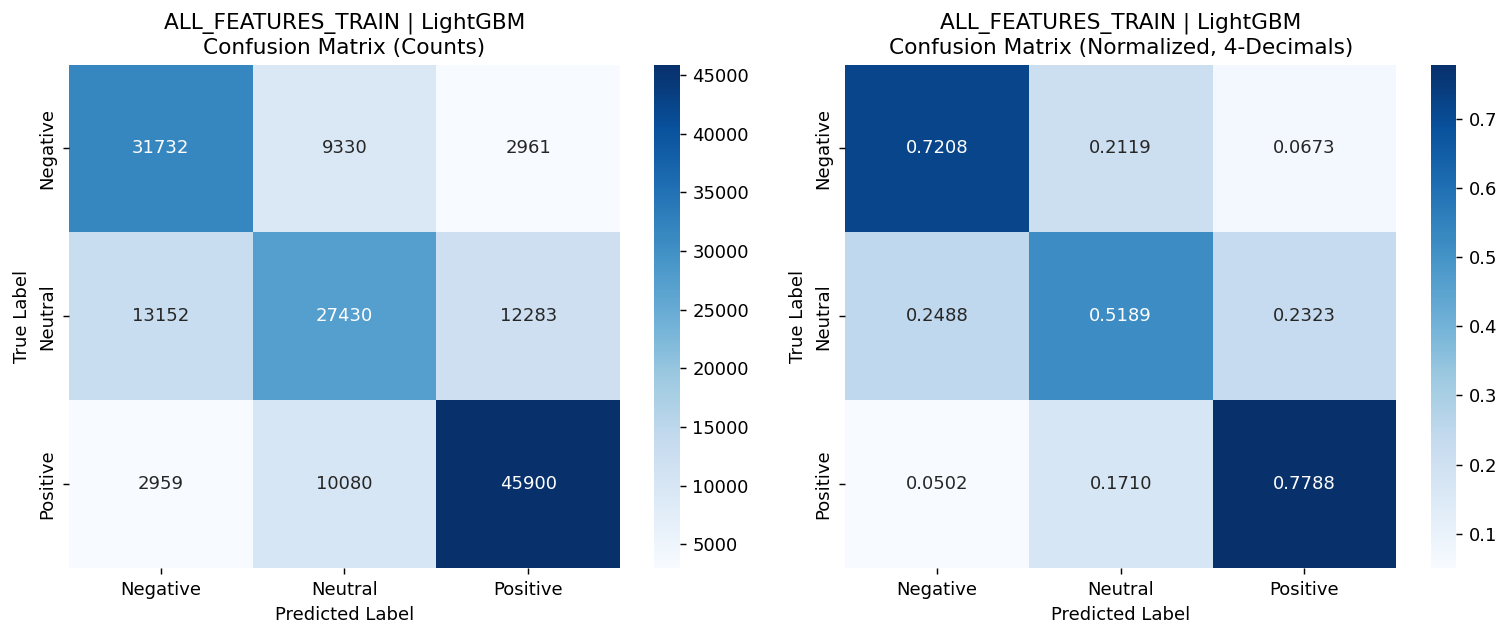


--- Per-Class Metrics (4 Decimals) ---
Negative  : Precision=0.6633  Recall=0.7208  F1=0.6908  Support=44023
Neutral   : Precision=0.5856  Recall=0.5189  F1=0.5502  Support=52865
Positive  : Precision=0.7507  Recall=0.7788  F1=0.7645  Support=58939

TEST SET PERFORMANCE

[ALL_FEATURES_TEST | LightGBM]
Accuracy=0.6349  F1_weighted=0.6313  Precision_weighted=0.6298  Recall_weighted=0.6349

--- Classification Report (4 Decimal Places) ---
              precision    recall  f1-score   support

    Negative     0.6245    0.6837    0.6528     11006
     Neutral     0.5230    0.4638    0.4916     13216
    Positive     0.7295    0.7520    0.7406     14735

    accuracy                         0.6349     38957
   macro avg     0.6257    0.6331    0.6283     38957
weighted avg     0.6298    0.6349    0.6313     38957



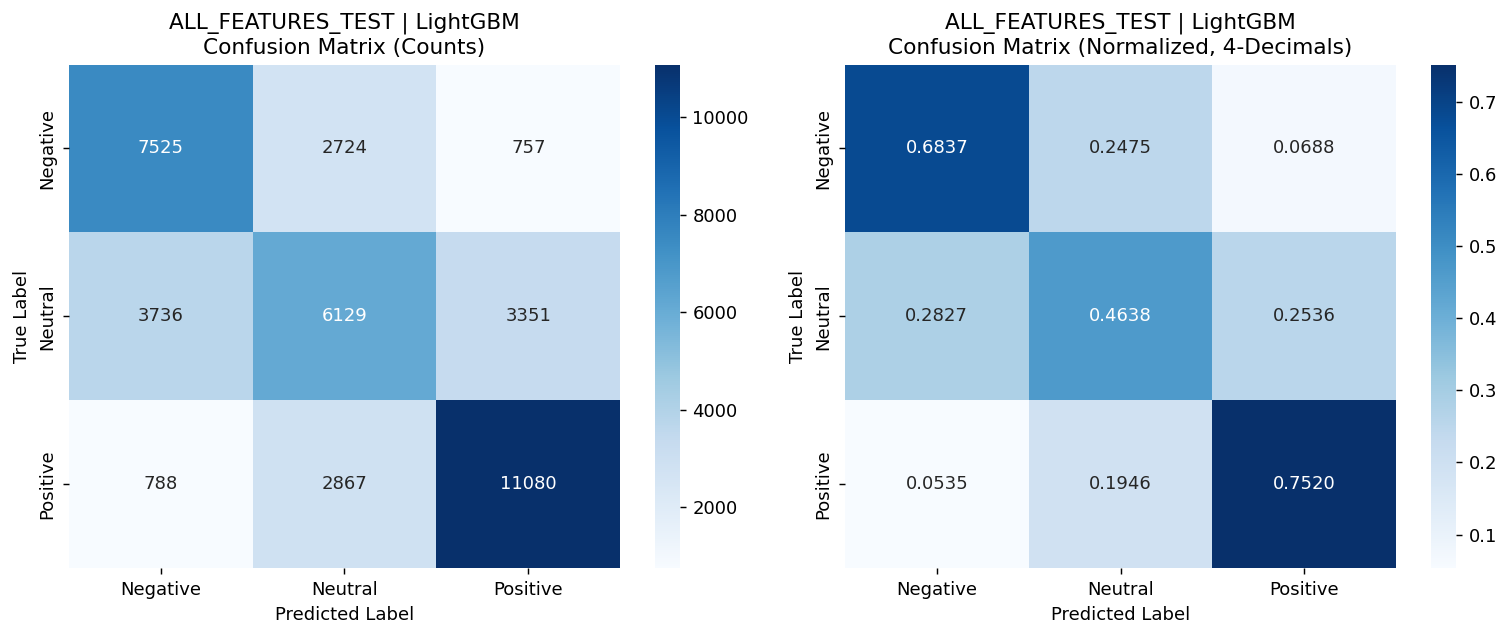


--- Per-Class Metrics (4 Decimals) ---
Negative  : Precision=0.6245  Recall=0.6837  F1=0.6528  Support=11006
Neutral   : Precision=0.5230  Recall=0.4638  F1=0.4916  Support=13216
Positive  : Precision=0.7295  Recall=0.7520  F1=0.7406  Support=14735

✅ Model saved to: /kaggle/working/LightGBM_Multiclass/ALL_FEATURES/LightGBM_ALL_Multiclass.pkl


In [14]:
# ======================================================================
# LIGHTGBM — ALL FEATURES (CPU Optimized for Sparse Data)
# ======================================================================

setup = "ALL_FEATURES"
save_dir = os.path.join(BASE_SAVE_DIR, setup)
os.makedirs(save_dir, exist_ok=True)

print(f"\n{'='*70}")
print(f"LIGHTGBM — ALL FEATURES (Multiclass)")
print(f"{'='*70}")

# Create LightGBM Dataset
# Note: LightGBM handles sparse matrices natively
print("Creating LightGBM Datasets...")
sample_weights_train = np.array([class_weight_dict[label] for label in y_train])
train_data_all = lgb.Dataset(X_train_ALL, label=y_train, weight=sample_weights_train)
test_data_all = lgb.Dataset(X_test_ALL, label=y_test, reference=train_data_all)

# ⭐ LIGHTGBM MULTICLASS CLASSIFICATION PARAMS
lgb_params = {
    'objective': 'multiclass',
    'num_class': N_CLASSES,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    
    # Model Complexity
    'max_depth': 4,
    'num_leaves': 15,  
    'learning_rate': 0.1,
    
    # Regularization & Sampling
    'bagging_fraction': 0.8, # subsample
    'bagging_freq': 1,
    'feature_fraction': 0.8, # colsample_bytree
    'min_child_weight': 10,
    'lambda_l1': 0.5, # reg_alpha
    'lambda_l2': 2.0, # reg_lambda
    
    # SWITCH TO CPU FOR STABILITY WITH SPARSE DATA
    'device': 'cpu', 
    'n_jobs': -1,  # Use all available Kaggle CPU cores
    
    'seed': RNG,
    'verbose': -1
}

# ---- K-FOLD CROSS-VALIDATION ----
print("\nRunning 5-Fold Cross-Validation...")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG)
cv_scores = []

for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train_ALL, y_train), 1):
    X_tr_fold = X_train_ALL[tr_idx]
    X_val_fold = X_train_ALL[val_idx]
    y_tr_fold = y_train[tr_idx]
    y_val_fold = y_train[val_idx]
    
    w_tr_fold = np.array([class_weight_dict[label] for label in y_tr_fold])
    
    dtrain_fold = lgb.Dataset(X_tr_fold, label=y_tr_fold, weight=w_tr_fold)
    dval_fold = lgb.Dataset(X_val_fold, label=y_val_fold, reference=dtrain_fold)
    
    callbacks = [
        lgb.early_stopping(stopping_rounds=50, verbose=False),
        lgb.log_evaluation(period=0) # Silence per-fold logs
    ]
    
    model_fold = lgb.train(
        lgb_params,
        dtrain_fold,
        num_boost_round=1000,
        valid_sets=[dtrain_fold, dval_fold],
        callbacks=callbacks
    )
    
    # Predict
    y_pred_prob_fold = model_fold.predict(X_val_fold)
    y_pred_fold = np.argmax(y_pred_prob_fold, axis=1)
    
    acc = accuracy_score(y_val_fold, y_pred_fold)
    f1 = precision_recall_fscore_support(y_val_fold, y_pred_fold, average='weighted', zero_division=0)[2]
    cv_scores.append((acc, f1))
    print(f"  Fold {fold}: acc={acc:.4f} | f1_weighted={f1:.4f}")

cv_arr = np.array(cv_scores)
print(f"  LightGBM (ALL Features) CV mean±std | acc={cv_arr[:,0].mean():.4f}±{cv_arr[:,0].std():.4f} f1_w={cv_arr[:,1].mean():.4f}±{cv_arr[:,1].std():.4f}")

# ---- FIT ON FULL TRAIN ----
print("\nTraining on full training set...")
callbacks = [
    lgb.early_stopping(stopping_rounds=50),
    lgb.log_evaluation(period=100)
]

lgb_all = lgb.train(
    lgb_params,
    train_data_all,
    num_boost_round=1000,
    valid_sets=[train_data_all, test_data_all],
    valid_names=['train', 'test'],
    callbacks=callbacks
)

# ---- PREDICTIONS ----
print("\nMaking predictions...")
train_prob = lgb_all.predict(X_train_ALL)
train_pred = np.argmax(train_prob, axis=1)

test_prob = lgb_all.predict(X_test_ALL)
test_pred = np.argmax(test_prob, axis=1)

# ---- EVALUATION ----
print(f"\n{'='*70}")
print("TRAIN SET PERFORMANCE")
print(f"{'='*70}")
train_metrics = evaluate_and_plot(
    "LightGBM", f"{setup}_TRAIN", y_train, train_prob, train_pred, save_dir
)

print(f"\n{'='*70}")
print("TEST SET PERFORMANCE")
print(f"{'='*70}")
test_metrics = evaluate_and_plot(
    "LightGBM", f"{setup}_TEST", y_test, test_prob, test_pred, save_dir
)

# ---- SAVE MODEL ----
model_path = os.path.join(save_dir, "LightGBM_ALL_Multiclass.pkl")
with open(model_path, "wb") as f:
    pickle.dump({
        "model": lgb_all,
        "tfidf_review": tfidf_review,
        "tfidf_title": tfidf_title,
        "scaler": scaler_all,
        "mlb": mlb_all,
        "ohe": ohe_all,
        "num_cols": NUM_COLS,
        "class_names": class_names,
        "class_weight_dict": class_weight_dict,
        "lgb_params": lgb_params
    }, f)

print(f"\n✅ Model saved to: {model_path}")